# Cleaning API Returned Data and Creating Features

### Call in packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import nltk
from nltk.tokenize import wordpunct_tokenize

import sys
import re

import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set_context('poster', font_scale=.8)

pd.set_option("display.max_colwidth", -1)

In [3]:
dog_data_SF = pd.read_csv("Model_Data/dog_data_SF_19.csv")

# dog_data_SF = pd.read_csv("Model_Data/dog_data_STL.csv")

In [4]:
#dog_data_SF =dog_data_SF.set_index('animal_id')
print(dog_data_SF.columns)
print(dog_data_SF.shape)


Index(['Unnamed: 0', 'num_photo', 'url', 'age', 'gender', 'size', 'coat',
       'name', 'status', 'breeds.primary', 'breeds.mixed', 'colors.primary',
       'attributes.spayed_neutered', 'attributes.house_trained',
       'attributes.special_needs', 'attributes.shots_current',
       'environment.children', 'environment.dogs', 'environment.cats',
       'contact.address.city', 'animal_id', 'pub_year', 'pub_month',
       'pub_time', 'stat_time', 'time_in_shelter', 'easy_adopt', 'tags_cln',
       'tags_top', 'num_tags', 'missing_description', 'colors_cat',
       'age_Adult', 'age_Baby', 'age_Senior', 'age_Young', 'gender_Female',
       'gender_Male', 'size_Extra Large', 'size_Large', 'size_Medium',
       'size_Small', 'coat_Curly', 'coat_Hairless', 'coat_Long', 'coat_Medium',
       'coat_Short', 'coat_Wire', 'colors_cat_ct_dark', 'colors_cat_ct_light',
       'colors_cat_ct_med', 'pub_month_1', 'pub_month_2', 'pub_month_3',
       'pub_month_4', 'pub_month_5', 'pub_month_6', 'pub_

Features that should  be numeric:
    - 'num_photo'

Features to keep as cats:
    - 'age'
    - 'gender'
    - 'size'
    - 'coat'
    - 'tags' - create a dummy if has tags or no, number of tags
    - 'bread-primary'
    - 'colors.primary'
    - 'attributes.spayed_neutered'
    - 'attributes.house_trained',
    - 'attributes.special_needs',
    - 'attributes.shots_current', 
    - 'environment.children', 
    - 'environment.dogs',
    - 'environment.cats'
    - 'contact.address.city' (as dummies)
    - 'pub_year',
    - 'pub_month', 
    - 'full_description' (if has one)

Features I need to improve the NLP model
    - 'tags'
    - 'full_description'


In [5]:
## Drop variables we won't include in the model
unneeded = [
    "species",
    "type",
    "attributes.declawed",
    "distance",
    "breeds.unknown",
    "contact.email",
    "contact.phone",
    "contact.address.address1",
    "contact.address.address2",
    "contact.address.country",
    "animal_type",
    "contact.address.state",
    "breeds.secondary",
    "colors.secondary",
    "colors.tertiary",
    "contact.address.postcode",
    "id",  ## redundant
    "photo",
    "photos",
    "organization_id"
]

dog_data_SF = dog_data_SF.drop(unneeded, axis=1)

In [6]:
dog_data_SF.columns

Index(['animal_id', 'age', 'attributes.house_trained',
       'attributes.shots_current', 'attributes.spayed_neutered',
       'attributes.special_needs', 'breeds.mixed', 'breeds.primary', 'coat',
       'colors.primary', 'contact.address.city', 'description',
       'environment.cats', 'environment.children', 'environment.dogs',
       'gender', 'name', 'organization_id.1', 'published_at', 'size', 'status',
       'status_changed_at', 'tags', 'url', 'num_photo', 'pub_year',
       'pub_month', 'pub_day', 'missing_description'],
      dtype='object')

In [8]:
# dog_data_SF.head()

In [9]:
dog_data_SF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 29 columns):
animal_id                     5961 non-null int64
age                           5961 non-null object
attributes.house_trained      5961 non-null bool
attributes.shots_current      5961 non-null bool
attributes.spayed_neutered    5961 non-null bool
attributes.special_needs      5961 non-null bool
breeds.mixed                  5961 non-null bool
breeds.primary                5961 non-null object
coat                          3732 non-null object
colors.primary                3315 non-null object
contact.address.city          5961 non-null object
description                   5858 non-null object
environment.cats              2273 non-null object
environment.children          3641 non-null object
environment.dogs              4617 non-null object
gender                        5961 non-null object
name                          5961 non-null object
organization_id.1             5961 no

In [8]:
# dog_data_SF.describe(include="all")

### Extracting time to adoption

In [10]:
## Create truncated string of data
dog_data_SF["published_at"] = dog_data_SF["published_at"].str[0:10]

dog_data_SF["status_changed_at"] = dog_data_SF["status_changed_at"].str[0:10]

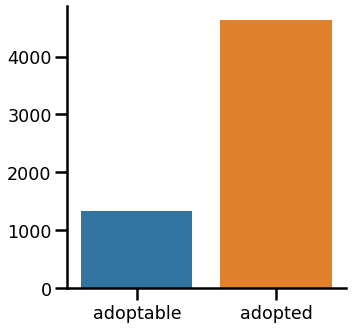

In [12]:
status_fig = sns.catplot(
    x="status",
    kind="count",
    # hue="status",
    data=dog_data_SF[dog_data_SF["pub_year"] == 2019],
)

status_fig.set(xlabel="", ylabel="",title="")
status_fig.set(xlabel="", ylabel="",title="")

plt.savefig("Demo_Figures/status_2019_SF.png")
plt.show()

In [13]:
dog_data_SF = dog_data_SF[(dog_data_SF['status']=='adopted') ]

In [14]:
date_format = "%Y-%m-%d"

def date_conversion(string_date):
    return dt.datetime.strptime(string_date, date_format)

In [15]:
dog_data_SF["pub_time"] = dog_data_SF["published_at"].apply(date_conversion)
dog_data_SF["stat_time"] = dog_data_SF["status_changed_at"].apply(date_conversion)

In [16]:
dog_data_SF["pub_time"].head()

90    2019-09-27
117   2019-09-27
146   2019-09-26
167   2019-09-26
170   2019-09-26
Name: pub_time, dtype: datetime64[ns]

In [17]:
dog_data_SF["stat_time"].head()

90    2019-09-27
117   2019-09-27
146   2019-09-27
167   2019-09-26
170   2019-09-28
Name: stat_time, dtype: datetime64[ns]

In [18]:
dog_data_SF["time_in_shelter"] = (
    dog_data_SF["stat_time"] - dog_data_SF["pub_time"]
).astype("timedelta64[D]")

In [19]:
dog_data_SF["time_in_shelter"].describe()

count    4633.000000
mean     18.665444  
std      23.212521  
min      0.000000   
25%      3.000000   
50%      11.000000  
75%      25.000000  
max      165.000000 
Name: time_in_shelter, dtype: float64

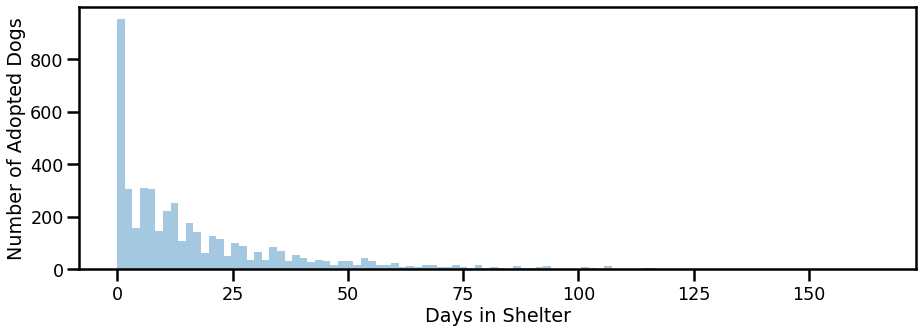

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(
    dog_data_SF["time_in_shelter"][dog_data_SF["status"] == "adopted"],
    kde=False, bins=100, ax=ax
)
ax.set(xlabel="Days in Shelter", ylabel="Number of Adopted Dogs");
fig.subplots_adjust(bottom=0.15)
plt.savefig("Demo_Figures/day_in_shelter_SF.png")


In [21]:
sum(dog_data_SF["time_in_shelter"] < 2)/len(dog_data_SF["time_in_shelter"])

0.20548240880638896

In [22]:
sum((dog_data_SF["time_in_shelter"] > 2) & (dog_data_SF["time_in_shelter"] < 93)) / len(
    dog_data_SF["time_in_shelter"]
)

0.7388301316641485

In [23]:
sum(dog_data_SF["time_in_shelter"] < 2)/len(dog_data_SF["time_in_shelter"]) + sum((dog_data_SF["time_in_shelter"] > 2) & (dog_data_SF["time_in_shelter"] < 93)) / len(
    dog_data_SF["time_in_shelter"]
)

0.9443125404705375

In [24]:
sum(dog_data_SF["time_in_shelter"] > 90)

102

In [25]:
sum(dog_data_SF["time_in_shelter"] < 2)

952

In [27]:
dog_data_SF['time_adpt_med'] =1*(dog_data_SF['time_in_shelter'] < 14)

### Cleaning up categorical features

    - 'age'
    - 'gender'
    - 'size'
    - 'coat'
    - 'bread-primary'
    - 'colors.primary'
    - 'attributes.spayed_neutered'
    - 'attributes.house_trained',
    - 'attributes.special_needs',
    - 'attributes.shots_current', 
    - 'environment.children', 
    - 'environment.dogs',
    - 'environment.cats'
    - 'pub_year',
    - 'pub_month',
    
    - 'contact.address.city' (as dummies)
    - 'pub_month' (as dummies)
    - 'tags' - create a dummy if has tags or no, number of tags
    - 'full_description' (if has one)


In [28]:
dog_data_SF['tags'].apply(len).head()

90     2 
117    2 
146    39
167    2 
170    2 
Name: tags, dtype: int64

In [29]:
dog_data_SF["tags_cln"] = dog_data_SF["tags"].apply(lambda x: x[1:-1].lower().strip())

tags = sum(dog_data_SF["tags_cln"].apply(lambda x: x.split(",")), [])


In [30]:
all_tags = pd.DataFrame(tags)

In [31]:
def to_lower(str_list):
    return str_list.lower().strip()

In [32]:
all_tags = all_tags[0].apply(to_lower)


In [33]:
all_tags.value_counts()

                                         4029
'loving'                                 347 
'playful'                                329 
'sweet'                                  169 
'active'                                 164 
'smart'                                  99  
'friendly'                               67  
'happy'                                  60  
'puppy'                                  48  
'loyal'                                  45  
'gentle'                                 40  
'affectionate'                           39  
'fun'                                    39  
'cute'                                   37  
'calm'                                   30  
'energetic'                              29  
'cuddly'                                 29  
'adorable'                               27  
''                                       23  
'intelligent'                            20  
'curious'                                19  
'mellow'                          

In [34]:
tag_freq = all_tags.value_counts()
tag_freq.head()

             4029
'loving'     347 
'playful'    329 
'sweet'      169 
'active'     164 
Name: 0, dtype: int64

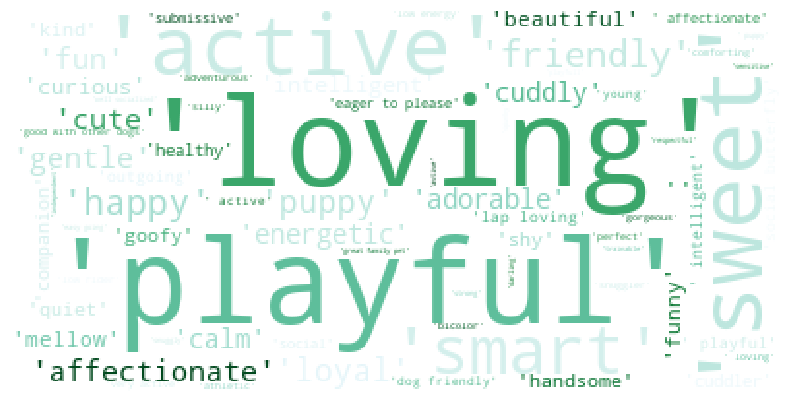

In [35]:
wordcloud = WordCloud(background_color="white", colormap ='BuGn_r').generate_from_frequencies(tag_freq)

# Generate plot
plt.figure(figsize=(10, 10), dpi=100)
plt.imshow(wordcloud)
plt.axis("off")


plt.savefig("Demo_Figures/word_cloud_SF.png", dpi=500)

In [36]:
top_tags = ["loving", "playful", "sweet", "friendly", "active"]

def top_tg(str_list):
    for tgs in top_tags:
        if tgs in str_list:
            return tgs
    

In [37]:
dog_data_SF["tags_top"] = dog_data_SF["tags_cln"].apply(top_tg)

In [38]:
pd.Categorical.describe(dog_data_SF["tags_top"])

,counts,freqs
categories,,
NaN,4078,0.880207
loving,366,0.078998
playful,119,0.025685
sweet,46,0.009929
friendly,15,0.003238
active,9,0.001943


In [39]:
dog_data_SF['num_tags'] = dog_data_SF['tags'].apply(len)
dog_data_SF['missing_description'] = pd.isnull(dog_data_SF['description'])

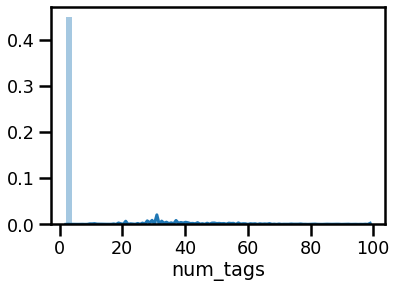

In [40]:
sns.distplot(dog_data_SF['num_tags']);

In [42]:
dog_data_SF = dog_data_SF.drop(
    ["tags", "description", "status_changed_at", "published_at"],
    axis=1,
)
dog_data_SF.columns

Index(['animal_id', 'age', 'attributes.house_trained',
       'attributes.shots_current', 'attributes.spayed_neutered',
       'attributes.special_needs', 'breeds.mixed', 'breeds.primary', 'coat',
       'colors.primary', 'contact.address.city', 'environment.cats',
       'environment.children', 'environment.dogs', 'gender', 'name',
       'organization_id.1', 'size', 'status', 'url', 'num_photo', 'pub_year',
       'pub_month', 'pub_day', 'missing_description', 'pub_time', 'stat_time',
       'time_in_shelter', 'time_adpt_med', 'tags_cln', 'tags_top', 'num_tags'],
      dtype='object')

#### reclassify coat color

In [43]:
recat_color = {
    "Apricot / Beige": "ct_light",
    "Brindle": "ct_light",
    "Golden": "ct_light",
    "Red / Chestnut / Orange": "ct_light",
    "White / Cream": "ct_light",
    "Yellow / Tan / Blond / Fawn": "ct_light",
    "Bicolor": "ct_med",
    "Gray / Blue / Silver": "ct_med",
    "Harlequin": "ct_med",
    "Merle (Blue)": "ct_med",
    "Merle (Red)": "ct_med",
    "Sable": "ct_med",
    "Tricolor (Brown, Black, & White)": "ct_med",
    "Black": "ct_dark",
    "Brown / Chocolate": "ct_dark",
}

dog_data_SF["colors_cat"] = dog_data_SF["colors.primary"].map(recat_color)

In [44]:
pd.Categorical.describe(dog_data_SF['colors.primary'])

,counts,freqs
categories,,
NaN,1929,0.416361
Black,871,0.187999
White / Cream,295,0.063674
Brown / Chocolate,286,0.061731
Bicolor,257,0.055472
"Tricolor (Brown, Black, & White)",190,0.041010
Yellow / Tan / Blond / Fawn,158,0.034103
Apricot / Beige,151,0.032592
Red / Chestnut / Orange,131,0.028275


In [45]:
pd.Categorical.describe(dog_data_SF['colors_cat'])

,counts,freqs
categories,,
NaN,1929,0.416361
ct_dark,1157,0.249730
ct_light,939,0.202676
ct_med,608,0.131232


In [46]:
sum(pd.isnull(dog_data_SF['colors_cat']))

1929

In [47]:
pd.crosstab(pd.isnull(dog_data_SF['colors_cat'])==True,dog_data_SF['pub_year'])

pub_year,2019
colors_cat,
False,2704
True,1929


In [48]:
pd.Categorical.describe(dog_data_SF['coat'])

,counts,freqs
categories,,
Short,2115,0.456508
NaN,1576,0.340168
Medium,686,0.148068
Long,159,0.034319
Wire,56,0.012087
Curly,40,0.008634
Hairless,1,0.000216


In [49]:
pd.crosstab(dog_data_SF['coat'],dog_data_SF['pub_year'])

pub_year,2019
coat,
Curly,40
Hairless,1
Long,159
Medium,686
Short,2115
Wire,56


In [50]:
cat_features = ["age", "gender", "size", "coat", "colors_cat", "pub_month", "pub_year", "tags_top"]

# 'breeds.primary', 'breeds.mixed', 'breeds.unknown', 'contact.address.city'

In [51]:
def gen_dummies(dataset, variable_list):
    for var in variable_list:
        dataset = pd.concat([dataset, pd.get_dummies(dataset[var], prefix=var)], axis=1)
    return dataset

In [52]:
dog_data_SF = gen_dummies(dog_data_SF, cat_features)

dog_data_SF.describe()

,animal_id,num_photo,pub_year,pub_month,pub_day,time_in_shelter,time_adpt_med,num_tags,age_Adult,age_Baby,...,pub_month_6,pub_month_7,pub_month_8,pub_month_9,pub_year_2019,tags_top_active,tags_top_friendly,tags_top_loving,tags_top_playful,tags_top_sweet
count,4.633000e+03,4633.000000,4633.0,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000,...,4633.000000,4633.000000,4633.000000,4633.000000,4633.0,4633.000000,4633.000000,4633.000000,4633.000000,4633.000000
mean,4.511837e+07,3.007986,2019.0,6.346644,6.346644,18.665444,0.571552,6.941075,0.301317,0.388517,...,0.200086,0.198144,0.191668,0.079862,1.0,0.001943,0.003238,0.078998,0.025685,0.009929
std,4.562706e+05,1.671326,0.0,1.525354,1.525354,23.212521,0.494907,14.084918,0.458879,0.487466,...,0.400108,0.398644,0.393656,0.271108,0.0,0.044037,0.056814,0.269766,0.158212,0.099158
min,4.437287e+07,0.000000,2019.0,4.000000,4.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.471620e+07,1.000000,2019.0,5.000000,5.000000,3.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.508719e+07,3.000000,2019.0,6.000000,6.000000,11.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.549831e+07,4.000000,2019.0,8.000000,8.000000,25.000000,1.000000,2.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.611011e+07,6.000000,2019.0,9.000000,9.000000,165.000000,1.000000,99.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [53]:
dog_data_SF.columns

Index(['animal_id', 'age', 'attributes.house_trained',
       'attributes.shots_current', 'attributes.spayed_neutered',
       'attributes.special_needs', 'breeds.mixed', 'breeds.primary', 'coat',
       'colors.primary', 'contact.address.city', 'environment.cats',
       'environment.children', 'environment.dogs', 'gender', 'name',
       'organization_id.1', 'size', 'status', 'url', 'num_photo', 'pub_year',
       'pub_month', 'pub_day', 'missing_description', 'pub_time', 'stat_time',
       'time_in_shelter', 'time_adpt_med', 'tags_cln', 'tags_top', 'num_tags',
       'colors_cat', 'age_Adult', 'age_Baby', 'age_Senior', 'age_Young',
       'gender_Female', 'gender_Male', 'size_Extra Large', 'size_Large',
       'size_Medium', 'size_Small', 'coat_Curly', 'coat_Hairless', 'coat_Long',
       'coat_Medium', 'coat_Short', 'coat_Wire', 'colors_cat_ct_dark',
       'colors_cat_ct_light', 'colors_cat_ct_med', 'pub_month_4',
       'pub_month_5', 'pub_month_6', 'pub_month_7', 'pub_month_8',

In [57]:
dog_data_SF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4633 entries, 90 to 5959
Data columns (total 64 columns):
animal_id                     4633 non-null int64
age                           4633 non-null object
attributes.house_trained      4633 non-null bool
attributes.shots_current      4633 non-null bool
attributes.spayed_neutered    4633 non-null bool
attributes.special_needs      4633 non-null bool
breeds.mixed                  4633 non-null bool
breeds.primary                4633 non-null object
coat                          3057 non-null object
colors.primary                2704 non-null object
contact.address.city          4633 non-null object
environment.cats              1812 non-null object
environment.children          2789 non-null object
environment.dogs              3591 non-null object
gender                        4633 non-null object
name                          4633 non-null object
organization_id.1             4633 non-null object
size                          4633 n

### Cleaning up boolean variables

In [54]:
dog_data_SF.select_dtypes(include='bool').head()

,attributes.house_trained,attributes.shots_current,attributes.spayed_neutered,attributes.special_needs,breeds.mixed,missing_description
90,True,True,True,False,True,False
117,False,True,True,False,True,False
146,True,True,True,False,True,False
167,True,True,True,False,True,False
170,False,True,True,False,True,False


In [56]:
dog_data_SF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4633 entries, 90 to 5959
Data columns (total 64 columns):
animal_id                     4633 non-null int64
age                           4633 non-null object
attributes.house_trained      4633 non-null bool
attributes.shots_current      4633 non-null bool
attributes.spayed_neutered    4633 non-null bool
attributes.special_needs      4633 non-null bool
breeds.mixed                  4633 non-null bool
breeds.primary                4633 non-null object
coat                          3057 non-null object
colors.primary                2704 non-null object
contact.address.city          4633 non-null object
environment.cats              1812 non-null object
environment.children          2789 non-null object
environment.dogs              3591 non-null object
gender                        4633 non-null object
name                          4633 non-null object
organization_id.1             4633 non-null object
size                          4633 n

In [58]:
for var in dog_data_SF.select_dtypes(include='bool').columns:
    dog_data_SF[var] = 1*dog_data_SF[var]

### Export clean data for modeling

In [1]:
# dog_data_SF.info()

In [62]:
dog_data_SF.shape

(4633, 64)

In [63]:
dog_data_SF.to_csv('Model_Data/dog_data_SF_19.csv')